In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from keras.models import Sequential
from keras.layers import Conv1D, Flatten, Dense,Dropout, Activation
from keras.layers import SimpleRNN, LSTM, Dense,GRU,Bidirectional
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.neural_network import MLPRegressor
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.linear_model import Ridge
from scipy.stats import pearsonr

In [ ]:
# Load the datta
df = pd.read_csv('/content/Ganga River_updated.csv')

In [ ]:
# Filter rows for each station
row = df[df['Station']=="Uttar Pradesh"]

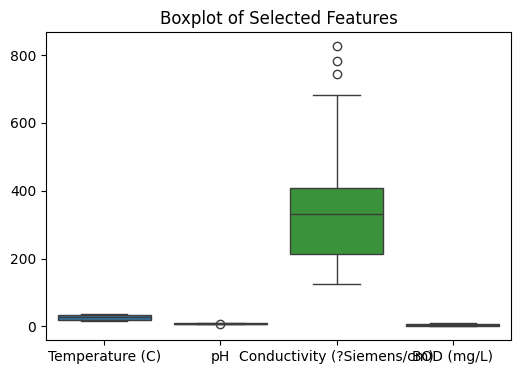

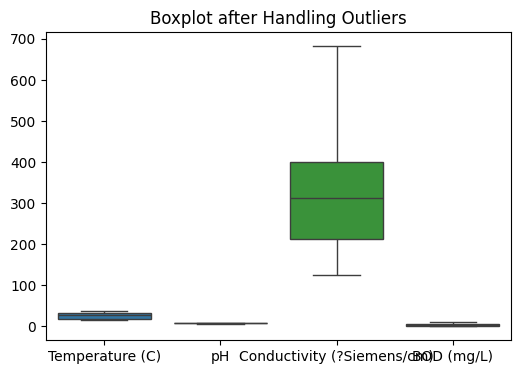

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Identify outliers using a boxplot
plt.figure(figsize=(6, 4))
sns.boxplot(data=row[['Temperature (C)','pH','Conductivity (?Siemens/cm)','BOD (mg/L)']])
plt.title('Boxplot of Selected Features')
plt.show()
# Iterate through each column in the selected features
for column in ['Temperature (C)','pH','Conductivity (?Siemens/cm)','BOD (mg/L)']:
    # Calculate quartiles and IQR
    q1 = row[column].quantile(0.25)
    q3 = row[column].quantile(0.75)
    iqr = q3 - q1
    # Define lower and upper bounds for outliers
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    # Identify outliers and replace them with the mean
    outliers = (row[column] < lower_bound) | (row[column] > upper_bound)
    mean_value = row.loc[~outliers, column].mean()
    row.loc[outliers, column] = mean_value
# Verify changes
plt.figure(figsize=(6, 4))
sns.boxplot(data=row[['Temperature (C)','pH','Conductivity (?Siemens/cm)','BOD (mg/L)']])  # Replace 'feature1', 'feature2', 'feature3' with your actual column names
plt.title('Boxplot after Handling Outliers')
plt.show()


In [ ]:
print(row)

         Station  Year  Temperature (C)    pH  Conductivity (?Siemens/cm)  \
160  West Bengal  2013             20.0  7.40                       230.0   
161  West Bengal  2013             32.0  7.80                       358.0   
162  West Bengal  2014             16.0  7.50                       193.0   
163  West Bengal  2014             32.0  8.10                       385.0   
164  West Bengal  2015             19.0  7.50                       213.0   
..           ...   ...              ...   ...                         ...   
249  West Bengal  2018             32.0  8.40                       442.0   
250  West Bengal  2019             21.0  7.00                       214.0   
251  West Bengal  2019             32.0  8.80                       372.0   
252  West Bengal  2020             18.0  7.70                       228.0   
253  West Bengal  2020             34.0  8.84                       384.0   

     BOD (mg/L)  Total coliform  D.O. (mg/L)  
160         4.5             

In [ ]:
#correlation
df.corr(method='pearson')

<ipython-input-8-ff23eb10992e>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr(method='pearson')


,Year,Temperature (C),pH,Conductivity (?Siemens/cm),BOD (mg/L),Total coliform,D.O. (mg/L)
Year,1.000000,0.075839,-0.034884,0.052047,-0.124775,-0.034752,0.040632
Temperature (C),0.075839,1.000000,0.763918,0.736047,0.655034,0.202834,-0.834528
pH,-0.034884,0.763918,1.000000,0.630247,0.581513,0.162319,-0.638366
Conductivity (?Siemens/cm),0.052047,0.736047,0.630247,1.000000,0.517452,0.183180,-0.657547
BOD (mg/L),-0.124775,0.655034,0.581513,0.517452,1.000000,0.192775,-0.732868
Total coliform,-0.034752,0.202834,0.162319,0.183180,0.192775,1.000000,-0.198014
D.O. (mg/L),0.040632,-0.834528,-0.638366,-0.657547,-0.732868,-0.198014,1.000000


In [ ]:
# Create train test split
X_train = row[row['Year'].isin([2013,2014,2015,2016,2017,2018])][['Temperature (C)','pH','Conductivity (?Siemens/cm)','BOD (mg/L)']]
X_val = row[row['Year'].isin([2019])][['Temperature (C)','pH','Conductivity (?Siemens/cm)','BOD (mg/L)']]
X_test = row[row['Year']==2020][['Temperature (C)','pH','Conductivity (?Siemens/cm)','BOD (mg/L)']]

y_train = row[row['Year'].isin([2013,2014,2015,2016,2017,2018])]['D.O. (mg/L)']
y_val = row[row['Year'].isin([2019])]['D.O. (mg/L)']
y_test = row[row['Year']==2020]['D.O. (mg/L)']

MULTIVARIATE LINEAR REGRESSION

In [ ]:
#LINEAR REGRESSION
# Normalize features and target variable using only training data
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = y_train   # no Scaling
y_val_scaled = y_val     # no scaling
y_test_scaled = y_test     # no scaling

# Linear Regression Model
LR_model = LinearRegression()
LR_model.fit(X_train_scaled, y_train_scaled)
# Predictions on Train and Test Sets
LR_train_pred = LR_model.predict(X_train_scaled)
LR_val_pred=LR_model.predict(X_val_scaled)
LR_test_pred = LR_model.predict(X_test_scaled)

# Evaluation Metrics
train_mse = mean_squared_error(y_train, LR_train_pred)
train_r2 = r2_score(y_train, LR_train_pred)
train_rmse = np.sqrt(train_mse)

val_r2 = r2_score(y_val, LR_val_pred)

# Print Evaluation Metrics for Training data set
mean_observed_train = np.mean(y_train)
train_index_of_agreement = 1 - (np.sum((y_train - LR_train_pred) ** 2) / np.sum((np.abs(y_train - mean_observed_train) + np.abs(LR_train_pred - mean_observed_train)) ** 2))

print('Training Index of Agreement:', train_index_of_agreement)
print('Training MSE:', train_mse)
print('Training R^2:', train_r2)
print('Training RMSE:', train_rmse)

# Print Evaluation Metrics for Validation data set
print('\nValidation R2 R^2:', val_r2)  #this parameter will be used to get the best paraper values

Training Index of Agreement: 0.9713055533931432
Training MSE: 0.6762565933875616
Training R^2: 0.8943195404816819
Training RMSE: 0.822348219057816

Validation R2 R^2: 0.7873912458116864


In [ ]:
#LINEAR REGRESSION
# Print Evaluation Metrics for Test data set
mean_observed_test = np.mean(y_test)
test_index_of_agreement = 1 - (np.sum((y_test - LR_test_pred) ** 2) / np.sum((np.abs(y_test - mean_observed_test) + np.abs(LR_test_pred - mean_observed_test)) ** 2))
test_mse = mean_squared_error(y_test, LR_test_pred)
test_r2 = r2_score(y_test, LR_test_pred)
test_rmse = np.sqrt(test_mse)

print('\nTesting Index of Agreement:', test_index_of_agreement)
print('Testing MSE:', test_mse)
print('Testing R^2:', test_r2)
print('Test RMSE:', test_rmse)


Testing Index of Agreement: 0.919230640283465
Testing MSE: 2.6346486545895758
Testing R^2: 0.7425616937790346
Test RMSE: 1.623160082859844


MULTIVARIATE POLYNOMIAL REGRESSION

In [ ]:
#polynomial Regression
# Normalize features and target variable using only training data
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = y_train   # no Scaling
y_val_scaled = y_val       # no scaling
y_test_scaled = y_test     # no scaling

# Importing Polynomial Regression Model
grid_degree = [1,2, 3, 4, 5, 6]
alpha = [1,1e-1]
train_r2 = 0
best_r2_val = -float('inf')
best_degree = None
best_alpha = None

for d in grid_degree:
    for a in alpha:
        pr_model = make_pipeline(PolynomialFeatures(degree=d), Ridge(alpha=a))
        pr_model.fit(X_train_scaled, y_train_scaled)

        # Predictions on Train and Validation Sets
        pr_train_pred = pr_model.predict(X_train_scaled)
        pr_val_pred = pr_model.predict(X_val_scaled)

        # Evaluation Metrics on Validation Set
        val_r2 = r2_score(y_val, pr_val_pred)
        print("Degree:", d, "| Alpha:", a, "| Validation R^2:", val_r2)

        # Check if this degree and alpha gives better R^2 on validation set
        if val_r2 > best_r2_val:
            best_r2_val = val_r2
            best_degree = d
            best_alpha = a

# Train the final model using the best degree and alpha
pr_model = make_pipeline(PolynomialFeatures(degree=best_degree), Ridge(alpha=best_alpha))
pr_model.fit(X_train_scaled, y_train_scaled)

# Predictions on Train and Test Sets
pr_train_pred = pr_model.predict(X_train_scaled)
pr_val_pred = pr_model.predict(X_val_scaled)
pr_test_pred = pr_model.predict(X_test_scaled)

# Evaluation Metrics for training set
train_mse = mean_squared_error(y_train, pr_train_pred)
train_r2 = r2_score(y_train, pr_train_pred)
train_rmse = np.sqrt(train_mse)
mean_observed_train = np.mean(y_train)
train_index_of_agreement = 1 - (np.sum((y_train - pr_train_pred) ** 2) / np.sum((np.abs(y_train - mean_observed_train) + np.abs(pr_train_pred - mean_observed_train)) ** 2))
# Print Evaluation Metrics on training data
print('Best Degree:', best_degree)
print('Best Alpha:', best_alpha)
print('\nTraining MSE:', train_mse)
print('Training R^2:', train_r2)
print('Training RMSE:', train_rmse)
print('Training Index of Agreement:', train_index_of_agreement)

#Evaluation metrics on validation data for r2 value
val_r2 = r2_score(y_val, pr_val_pred)
print('\nValidation R^2:', val_r2)


Degree: 1 | Alpha: 1 | Validation R^2: 0.8177584553647865
Degree: 1 | Alpha: 0.1 | Validation R^2: 0.796745026529988
Degree: 2 | Alpha: 1 | Validation R^2: 0.7791505254450948
Degree: 2 | Alpha: 0.1 | Validation R^2: 0.7799674109613488
Degree: 3 | Alpha: 1 | Validation R^2: 0.7522736447473941
Degree: 3 | Alpha: 0.1 | Validation R^2: 0.8081443030142094
Degree: 4 | Alpha: 1 | Validation R^2: 0.7521432936370467
Degree: 4 | Alpha: 0.1 | Validation R^2: 0.8256084800279435
Degree: 5 | Alpha: 1 | Validation R^2: 0.7659821923815815
Degree: 5 | Alpha: 0.1 | Validation R^2: 0.8145856830630033
Degree: 6 | Alpha: 1 | Validation R^2: 0.78021542463331
Degree: 6 | Alpha: 0.1 | Validation R^2: 0.7669937422356108
Best Degree: 4
Best Alpha: 0.1

Training MSE: 0.5580500519707595
Training R^2: 0.9127919986242667
Training RMSE: 0.7470274773867154
Training Index of Agreement: 0.9764528061475917

Validation R^2: 0.8256084800279435


In [ ]:
#Polynomial Regression
#Evaluation on testing data
test_mse = mean_squared_error(y_test, pr_test_pred)
test_r2 = r2_score(y_test, pr_test_pred)
test_rmse = np.sqrt(test_mse)
mean_observed_test = np.mean(y_test)
test_index_of_agreement = 1 - (np.sum((y_test - pr_test_pred) ** 2) / np.sum((np.abs(y_test - mean_observed_test) + np.abs(pr_test_pred - mean_observed_test)) ** 2))
print('\nTesting MSE:', test_mse)
print('Testing R^2:', test_r2)
print('Test RMSE:', test_rmse)
print('Testing Index of Agreement:', test_index_of_agreement)



Testing MSE: 3.0013933976593763
Testing R^2: 0.7067261202930357
Test RMSE: 1.7324530001299823
Testing Index of Agreement: 0.9046812475952235


RECURRENT NEURAL NETWORK

In [ ]:
#Simple RNN
# Normalize features and target variable using only training data
scaler_X = MinMaxScaler()
scaler_X.fit(X_train)
X_train_scaled = scaler_X.transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = MinMaxScaler()
scaler_y.fit(y_train.values.reshape(-1, 1))
y_train_scaled = scaler_y.transform(y_train.values.reshape(-1, 1)).ravel()
# Reshape data for Simple RNN
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_val_reshaped = X_val_scaled.reshape((X_val_scaled.shape[0], 1, X_val_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Initialize variables to store best h and average validation R^2 value
best_h = None
best_batch_size = None
best_avg_val_r2 = -float('inf')

# Number of iterations
num_iterations = 10

# Lists to store metrics for each iteration
train_index_of_agreement_list = []
test_index_of_agreement_list = []
train_mse_list = []
train_r2_list = []
train_rmse_list = []
test_mse_list = []
test_r2_list = []
test_rmse_list = []

# Batch sizes to try
batch_sizes = [16, 32]
h_values=[50,100,150,200,220]
# Iterate through each value of batch size
for batch_size in batch_sizes:
    # Iterate through each value of h
    for h in h_values:
        # Lists to store validation R^2 values for each iteration
        val_r2_values = []

        # Perform multiple iterations for each h value and batch size
        for _ in range(num_iterations):
            # Model building and training with Simple RNN
            Rnn_model = Sequential()
            Rnn_model.add(SimpleRNN(h, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
            Rnn_model.add(Dropout(0.1))  # Adding dropout with a rate of 0.1
            Rnn_model.add(Dense(1))
            Rnn_model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

            # Early stopping to prevent overfitting
            early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

            # Fit the model
            Rnn_model.fit(X_train_reshaped, y_train_scaled, epochs=5000, batch_size=batch_size, validation_split=0.2, callbacks=[early_stopping], verbose=0)

            # Predictions on training set and validation set
            rnn_train_pred = Rnn_model.predict(X_train_reshaped).ravel()
            train_pred=scaler_y.inverse_transform(rnn_train_pred.reshape(-1,1)).ravel()
            rnn_val_pred = Rnn_model.predict(X_val_reshaped).ravel()
            val_pred = scaler_y.inverse_transform(rnn_val_pred.reshape(-1,1)).ravel()

            # Evaluation metrics on validation set
            val_r2 = r2_score(y_val, val_pred)
            val_r2_values.append(val_r2)

        # Calculate average validation R^2 for this h value and batch size
        avg_val_r2 = np.mean(val_r2_values)

        # Print average validation R^2 for this h value and batch size
        print("Batch size:", batch_size, "| Node:", h, "| Average Validation R^2:", avg_val_r2)

        # Check if this h value and batch size combination gives a better average validation R^2
        if avg_val_r2 > best_avg_val_r2:
            best_avg_val_r2 = avg_val_r2
            best_h = h
            best_batch_size = batch_size

# Print the best h value and batch size
print("Best h value:", best_h)
print("Best batch size:", best_batch_size)

for iteration in range(num_iterations):
  # Train the final model using the best h value
  Rnn_model = Sequential()
  Rnn_model.add(SimpleRNN(best_h, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
  Rnn_model.add(Dropout(0.1))  # Adding dropout with a rate of 0.1
  Rnn_model.add(Dense(1))
  Rnn_model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

  # Early stopping to prevent overfitting
  early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

  # Fit the model on entire training data
  Rnn_model.fit(X_train_reshaped, y_train_scaled, epochs=5000, batch_size=best_batch_size, validation_split=0.2, callbacks=[early_stopping], verbose=0)

  # Predictions on train and test
  rnn_train_pred = Rnn_model.predict(X_train_reshaped).ravel()
  rnn_test_pred= Rnn_model.predict(X_test_reshaped).ravel()
  #inverse transformation
  train_pred=scaler_y.inverse_transform(rnn_train_pred.reshape(-1,1)).ravel()
  test_pred=scaler_y.inverse_transform(rnn_test_pred.reshape(-1,1)).ravel()

  # Evaluation metrics
  train_mse = mean_squared_error(y_train, train_pred)
  train_r2 = r2_score(y_train, train_pred)
  train_rmse = np.sqrt(train_mse)
  test_mse = mean_squared_error(y_test, test_pred)
  test_r2 = r2_score(y_test, test_pred)
  test_rmse = np.sqrt(test_mse)

  # Calculate Index of Agreement for training set
  mean_observed_train = np.mean(y_train)
  train_index_of_agreement = 1 - (np.sum((y_train - train_pred) ** 2) / np.sum((np.abs(y_train - mean_observed_train) + np.abs(train_pred - mean_observed_train)) ** 2))

  # Calculate Index of Agreement for testing set
  mean_observed_test = np.mean(y_test)
  test_index_of_agreement = 1 - (np.sum((y_test - test_pred) ** 2) / np.sum((np.abs(y_test - mean_observed_test) + np.abs(test_pred- mean_observed_test)) ** 2))

  # Append results to lists
  train_index_of_agreement_list.append(train_index_of_agreement)
  test_index_of_agreement_list.append(test_index_of_agreement)
  train_mse_list.append(train_mse)
  train_r2_list.append(train_r2)
  train_rmse_list.append(train_rmse)
  test_mse_list.append(test_mse)
  test_r2_list.append(test_r2)
  test_rmse_list.append(test_rmse)




1/1 [==============================] - 0s 24ms/step
Node : 50 | Validation R^2: 0.7652361964413564
1/1 [==============================] - 0s 22ms/step
Node : 100 | Validation R^2: 0.7853865460237048
1/1 [==============================] - 0s 22ms/step
Node : 150 | Validation R^2: 0.767942978190129
1/1 [==============================] - 0s 22ms/step
Node : 200 | Validation R^2: 0.7720602690761549
1/1 [==============================] - 0s 22ms/step
Node : 222 | Validation R^2: 0.7617774169399544
1/1 [==============================] - 0s 22ms/step


In [ ]:
#Values for simple RNN
# Evaluation metrics for training set
avg_train_index_of_agreement = np.mean(train_index_of_agreement_list)
avg_train_mse = np.mean(train_mse_list)
avg_train_r2 = np.mean(train_r2_list)
avg_train_rmse = np.mean(train_rmse_list)

print("Average Train Index of Agreement:", avg_train_index_of_agreement)
print("Average Train MSE:", avg_train_mse)
print("Average Train R^2:", avg_train_r2)
print("Average Train RMSE:", avg_train_rmse)

val_r2 = r2_score(y_val, val_pred)
print('\nValidation R^2:', val_r2)

avg_test_mse = np.mean(test_mse_list)
avg_test_r2 = np.mean(test_r2_list)
avg_test_rmse = np.mean(test_rmse_list)
avg_test_index_of_agreement = np.mean(test_index_of_agreement_list)


print("\nAverage Test Index of Agreement:", avg_test_index_of_agreement)
print("Average Test MSE:", avg_test_mse)
print("Average Test R^2:", avg_test_r2)
print("Average Test RMSE:", avg_test_rmse)

Average Training MSE: 0.7312223728864049
Average Training R^2: 0.8857298884294595
Average Training RMSE: 0.8549669153349667
Average Training Index of Agreement: 0.969790385280532

Best h value based on R^2: 100
Validation R^2 with best h: 0.7853865460237048

Validation R^2: 0.7617774169399544

Average Testing MSE: 2.2785315630699676
Average Testing R^2: 0.7773588120579522
Average Test RMSE: 1.5068335216125592
Average Testing Index of Agreement: 0.9325352026931609


LSTM+RNN

In [ ]:
#LONG SHORT TERM MEMORY(LSTM)+RNN
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, SimpleRNN, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# Normalize features and target variable using only training data
scaler_X = MinMaxScaler()
scaler_X.fit(X_train)
X_train_scaled = scaler_X.transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = MinMaxScaler()
scaler_y.fit(y_train.values.reshape(-1, 1))
y_train_scaled = scaler_y.transform(y_train.values.reshape(-1, 1)).ravel()

# Reshape data for LSTM+RNN
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_val_reshaped = X_val_scaled.reshape((X_val_scaled.shape[0], 1, X_val_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Initialize variables to store best h and average validation R^2 value
best_h = None
best_batch_size = None
best_avg_val_r2 = -float('inf')

# Number of iterations
num_iterations = 10

# Lists to store metrics for each iteration
train_index_of_agreement_list = []
test_index_of_agreement_list = []
train_mse_list = []
train_r2_list = []
train_rmse_list = []
test_mse_list = []
test_r2_list = []
test_rmse_list = []

# Batch sizes to try
batch_sizes = [16, 32]
h_values = [50, 100, 150, 200, 220]

# Iterate through each value of batch size
for batch_size in batch_sizes:
    # Iterate through each value of h
    for h in h_values:
        # Lists to store validation R^2 values for each iteration
        val_r2_values = []

        # Perform multiple iterations for each h value and batch size
        for _ in range(num_iterations):
            # Model building and training with LSTM+RNN
            lstm_rnn_model = Sequential()
            lstm_rnn_model.add(LSTM(h, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]), return_sequences=True))
            lstm_rnn_model.add(Dropout(0.1))  # Adding dropout for regularization
            lstm_rnn_model.add(SimpleRNN(200))
            lstm_rnn_model.add(Dropout(0.1))  # Adding dropout for regularization
            lstm_rnn_model.add(Dense(1))
            lstm_rnn_model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

            # Early stopping to prevent overfitting
            early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

            # Fit the model
            lstm_rnn_model.fit(X_train_reshaped, y_train_scaled, epochs=5000, batch_size=batch_size, validation_split=0.2, callbacks=[early_stopping], verbose=0)

            # Predictions on training set and validation set
            lstm_rnn_train_pred = lstm_rnn_model.predict(X_train_reshaped).ravel()
            train_pred = scaler_y.inverse_transform(lstm_rnn_train_pred.reshape(-1, 1)).ravel()
            lstm_rnn_val_pred = lstm_rnn_model.predict(X_val_reshaped).ravel()
            val_pred = scaler_y.inverse_transform(lstm_rnn_val_pred.reshape(-1, 1)).ravel()

            # Evaluation metrics on validation set
            val_r2 = r2_score(y_val, val_pred)
            val_r2_values.append(val_r2)

        # Calculate average validation R^2 for this h value and batch size
        avg_val_r2 = np.mean(val_r2_values)

        # Print average validation R^2 for this h value and batch size
        print("Batch size:", batch_size, "| Node:", h, "| Average Validation R^2:", avg_val_r2)

        # Check if this h value and batch size combination gives a better average validation R^2
        if avg_val_r2 > best_avg_val_r2:
            best_avg_val_r2 = avg_val_r2
            best_h = h
            best_batch_size = batch_size

# Print the best h value and batch size
print("Best h value:", best_h)
print("Best batch size:", best_batch_size)

for iteration in range(num_iterations):
    # Train the final model using the best h value
    lstm_rnn_model = Sequential()
    lstm_rnn_model.add(LSTM(best_h, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]), return_sequences=True))
    lstm_rnn_model.add(Dropout(0.1))  # Adding dropout with a rate of 0.1
    lstm_rnn_model.add(SimpleRNN(200))
    lstm_rnn_model.add(Dropout(0.1))  # Adding dropout with a rate of 0.1
    lstm_rnn_model.add(Dense(1))
    lstm_rnn_model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Fit the model on entire training data
    lstm_rnn_model.fit(X_train_reshaped, y_train_scaled, epochs=5000, batch_size=best_batch_size, validation_split=0.2, callbacks=[early_stopping], verbose=0)

    # Predictions on train and test
    lstm_rnn_train_pred = lstm_rnn_model.predict(X_train_reshaped).ravel()
    lstm_rnn_test_pred = lstm_rnn_model.predict(X_test_reshaped).ravel()

    # Inverse transformation
    train_pred = scaler_y.inverse_transform(lstm_rnn_train_pred.reshape(-1, 1)).ravel()
    test_pred = scaler_y.inverse_transform(lstm_rnn_test_pred.reshape(-1, 1)).ravel()

    # Evaluation metrics
    train_mse = mean_squared_error(y_train, train_pred)
    train_r2 = r2_score(y_train, train_pred)
    train_rmse = np.sqrt(train_mse)
    test_mse = mean_squared_error(y_test, test_pred)
    test_r2 = r2_score(y_test, test_pred)
    test_rmse = np.sqrt(test_mse)

    # Calculate Index of Agreement for training set
    mean_observed_train = np.mean(y_train)
    train_index_of_agreement = 1 - (np.sum((y_train - train_pred) ** 2) / np.sum((np.abs(y_train - mean_observed_train) + np.abs(train_pred - mean_observed_train)) ** 2))

    # Calculate Index of Agreement for testing set
    mean_observed_test = np.mean(y_test)
    test_index_of_agreement = 1 - (np.sum((y_test - test_pred) ** 2) / np.sum((np.abs(y_test - mean_observed_test) + np.abs(test_pred - mean_observed_test)) ** 2))

    # Append results to lists
    train_index_of_agreement_list.append(train_index_of_agreement)
    test_index_of_agreement_list.append(test_index_of_agreement)
    train_mse_list.append(train_mse)
    train_r2_list.append(train_r2)
    train_rmse_list.append(train_rmse)
    test_mse_list.append(test_mse)
    test_r2_list.append(test_r2)
    test_rmse_list.append(test_rmse)



1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 20ms/step
Batch size: 16 | Node: 50 | Average Validation R^2: 0.6749501931244443
1/1 [==============================] - 0s 22ms/step
Batch size: 16 | Node: 100 | Average Validation R^2: 0.6819619553837236
1/1 [==============================] - 0s 31ms/step
Batch size: 16 | Node: 150 | Average Validation R^2: 0.6649356411332503
1/1 [==============================] - 0s 38ms/step
Batch size: 16 | Node: 200 | Average Validation R^2: 0.6955479804232091
1/1 [==============================] - 0s 23ms/step
Batch size: 16 | Node: 220 | Average Validation R^2: 0.6863164858376695
1/1 [==============================] - 0s 23ms/step
Batch size: 32 | Node: 50 | Average Validation R^2: 0.6493255909720466
1/1 [==============================] - 0s 22ms/step
Batch size: 32 | Node: 100 | Average Validation R^2: 0.688112329400945
1/1 [==============================] - 0s 21ms/step
Batch size: 32 | Node: 150 | Average Validation R^2: 0.6684373571682115
1/1 [======

In [ ]:
#Values for rnn+lstm
# Evaluation metrics for training set
avg_train_index_of_agreement = np.mean(train_index_of_agreement_list)
avg_train_mse = np.mean(train_mse_list)
avg_train_r2 = np.mean(train_r2_list)
avg_train_rmse = np.mean(train_rmse_list)

print('Average Training MSE:', avg_train_mse)
print('Average Training R^2:', avg_train_r2)
print('Average Training RMSE:', avg_train_rmse)
print('Average Training Index of Agreement:', avg_train_index_of_agreement)

val_r2=r2_score(y_val,val_pred)
print('\n Validation value of r2 score:',val_r2)

# Evaluation metrics for testing set
avg_test_mse = np.mean(test_mse_list)
avg_test_r2 = np.mean(test_r2_list)
avg_test_rmse = np.mean(test_rmse_list)
avg_test_index_of_agreement = np.mean(test_index_of_agreement_list)
print('\nAverage Testing MSE:', avg_test_mse)
print('Average Testing R^2:', avg_test_r2)
print('Average Test RMSE:', avg_test_rmse)
print('Average Testing Index of Agreement:', avg_test_index_of_agreement)


Average Training MSE: 0.6151248759763346
Average Training R^2: 0.7813944573900938
Average Training RMSE: 0.7836570302432693
Average Training Index of Agreement: 0.9365315966945532

 Validation value of r2 score: 0.6787278154120029

Average Testing MSE: 2.270200485659189
Average Testing R^2: 0.6414491620350008
Average Test RMSE: 1.5046939237061263
Average Testing Index of Agreement: 0.8449499971054264


MLPNN

In [ ]:
#MLPNN
# Normalize features and target variable using only training data
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)  # Scaling validation set
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = y_train   # no Scaling
y_val_scaled = y_val       # no scaling
y_test_scaled = y_test     # no scaling

# List of hidden layer configurations to try
hidden_layer_configurations = [(100, 50), (100, 75),(125, 50), (125, 75), (125, 100),
                                (150, 50), (150, 75), (150, 100), (150, 125),
                                (175, 50), (175, 75), (175, 100), (175, 125),
                                (200, 50), (200, 75), (200, 100), (200, 125)]

# Initialize lists to store results
train_index_of_agreement_list = []
test_index_of_agreement_list = []
train_mse_list = []
train_r2_list = []
train_rmse_list = []
test_mse_list = []
test_r2_list = []
test_rmse_list = []

# Initialize variables to store best configuration and its corresponding performance
best_config = None
best_val_r2 = -float('inf')

# Iterate over each hidden layer configuration
for h in hidden_layer_configurations:
  #  importing the Model  multilayer perceptron neural network
  mlp_model = MLPRegressor(random_state=42, hidden_layer_sizes=h, max_iter=2000).fit(X_train_scaled, y_train_scaled)

  # Predictions on training data and validation data
  mlp_train_pred = mlp_model.predict(X_train_scaled)
  mlp_val_pred = mlp_model.predict(X_val_scaled)

  # Evaluation metrics on validation set
  val_r2 = r2_score(y_val, mlp_val_pred)
  print("Nodes:", h, "| Validation R^2:", val_r2)


  # Check if this configuration performs better than the current best
  if val_r2 > best_val_r2:
      best_val_r2 = val_r2
      best_config = h
for i in range(20):
  # Use the best configuration on the testing set
  mlp_model = MLPRegressor(random_state=42, hidden_layer_sizes=best_config, max_iter=2000).fit(X_train_scaled, y_train_scaled)

  # Predictions on training and testing data
  mlp_train_pred = mlp_model.predict(X_train_scaled)
  mlp_test_pred = mlp_model.predict(X_test_scaled)

  # Finding the METRICS of the MLPNN model on testing set
  train_mse = mean_squared_error(y_train, mlp_train_pred)
  train_r2 = r2_score(y_train, mlp_train_pred)
  train_rmse = np.sqrt(train_mse)

  test_mse = mean_squared_error(y_test, mlp_test_pred)
  test_rmse = np.sqrt(test_mse)
  test_r2 = r2_score(y_test, mlp_test_pred)
  # Calculate Index of Agreement for training set
  mean_observed_train = np.mean(y_train)
  train_index_of_agreement = 1 - (np.sum((y_train - mlp_train_pred) ** 2) / np.sum((np.abs(y_train - mean_observed_train) + np.abs(mlp_train_pred - mean_observed_train)) ** 2))

  # Calculate Index of Agreement for testing set
  mean_observed_test = np.mean(y_test)
  test_index_of_agreement = 1 - (np.sum((y_test - mlp_test_pred) ** 2) / np.sum((np.abs(y_test - mean_observed_test) + np.abs(mlp_test_pred - mean_observed_test)) ** 2))
  # Append results to lists
  train_index_of_agreement_list.append(train_index_of_agreement)
  test_index_of_agreement_list.append(test_index_of_agreement)
  train_mse_list.append(train_mse)
  train_r2_list.append(train_r2)
  train_rmse_list.append(train_rmse)
  test_mse_list.append(test_mse)
  test_r2_list.append(test_r2)
  test_rmse_list.append(test_rmse)



Nodes: (100, 50) | Validation R^2: 0.8261624084832422
Nodes: (100, 75) | Validation R^2: 0.8114449306774596
Nodes: (125, 50) | Validation R^2: 0.8638973005096444


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


Nodes: (125, 75) | Validation R^2: 0.8720851176679506
Nodes: (125, 100) | Validation R^2: 0.8438497258914053
Nodes: (150, 50) | Validation R^2: 0.8727190438181436
Nodes: (150, 75) | Validation R^2: 0.8595465646613102


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


Nodes: (150, 100) | Validation R^2: 0.875668990320954
Nodes: (150, 125) | Validation R^2: 0.8374325163568487
Nodes: (175, 50) | Validation R^2: 0.8395319280766367
Nodes: (175, 75) | Validation R^2: 0.8414339233889707
Nodes: (175, 100) | Validation R^2: 0.8407644298308558
Nodes: (175, 125) | Validation R^2: 0.8450836442560121
Nodes: (200, 50) | Validation R^2: 0.841700794899313
Nodes: (200, 75) | Validation R^2: 0.8542970289614419
Nodes: (200, 100) | Validation R^2: 0.8528208981004777
Nodes: (200, 125) | Validation R^2: 0.8505013363191509


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perce

In [ ]:
#MLPNN
#MLPNN
# Calculate  result ON TRAINING DATa
avg_train_index_of_agreement = np.mean(train_index_of_agreement_list)
avg_train_mse = np.mean(train_mse_list)
avg_train_r2 = np.mean(train_r2_list)
avg_train_rmse = np.mean(train_rmse_list)
print('Average Training Index of Agreement:', avg_train_index_of_agreement)
print('Average Training MSE:', avg_train_mse)
print('Average Training R^2:', avg_train_r2)
print('Average Training RMSE:', avg_train_rmse)

print('Best hidden layer configuration:', best_config)

val_r2 = r2_score(y_val, mlp_val_pred)
print('\nvalidation on r2:',val_r2)

avg_test_index_of_agreement = np.mean(test_index_of_agreement_list)
avg_test_mse = np.mean(test_mse_list)
avg_test_r2 = np.mean(test_r2_list)
avg_test_rmse = np.mean(test_rmse_list)
print('\nAverage Testing Index of Agreement:', avg_test_index_of_agreement)
print('Average Testing MSE:', avg_test_mse)
print('Average Testing R^2:', avg_test_r2)
print('Average Testing RMSE:', avg_test_rmse)

Average Training Index of Agreement: 0.9873480156786515
Average Training MSE: 0.3107801338291954
Average Training R^2: 0.951433542129753
Average Training RMSE: 0.5574765769332334
Best hidden layer configuration: (150, 100)

validation on r2: 0.8505013363191509

Average Testing Index of Agreement: 0.849347411792639
Average Testing MSE: 4.213418300859106
Average Testing R^2: 0.5882960451352629
Average Testing RMSE: 2.052661272801508


GATED RECURRENT NETWORK(GRU)

In [ ]:
#GRU
# Normalize features and target variable using only training data
scaler_X = MinMaxScaler()
scaler_X.fit(X_train)
X_train_scaled = scaler_X.transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = MinMaxScaler()
scaler_y.fit(y_train.values.reshape(-1, 1))
y_train_scaled = scaler_y.transform(y_train.values.reshape(-1, 1)).ravel()

# Reshape data for GRU
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_val_reshaped = X_val_scaled.reshape((X_val_scaled.shape[0], 1, X_val_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Initialize variables to store best h and average validation R^2 value
best_h = None
best_batch_size = None
best_avg_val_r2 = -float('inf')

# Number of iterations
num_iterations = 10

# Lists to store metrics for each iteration
train_index_of_agreement_list = []
test_index_of_agreement_list = []
train_mse_list = []
train_r2_list = []
train_rmse_list = []
test_mse_list = []
test_r2_list = []
test_rmse_list = []

# Batch sizes to try
batch_sizes = [16, 32]
h_values = [50, 100, 150, 200, 220]

# Iterate through each value of batch size
for batch_size in batch_sizes:
    # Iterate through each value of h
    for h in h_values:
        # Lists to store validation R^2 values for each iteration
        val_r2_values = []

        # Perform multiple iterations for each h value and batch size
        for _ in range(num_iterations):
            # Model building and training with GRU
            gru_model = Sequential()
            gru_model.add(GRU(h, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
            gru_model.add(Dropout(0.1))  # Adding dropout with a rate of 0.1
            gru_model.add(Dense(1))
            gru_model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

            # Early stopping to prevent overfitting
            early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

            # Fit the model
            gru_model.fit(X_train_reshaped, y_train_scaled, epochs=5000, batch_size=batch_size, validation_split=0.2, callbacks=[early_stopping], verbose=0)

            # Predictions on testing set and validation set
            gru_train_pred = gru_model.predict(X_train_reshaped).ravel()
            train_pred = scaler_y.inverse_transform(gru_train_pred.reshape(-1, 1)).ravel()
            gru_val_pred = gru_model.predict(X_val_reshaped).ravel()
            val_pred = scaler_y.inverse_transform(gru_val_pred.reshape(-1, 1)).ravel()

            # Evaluation metrics on validation set
            val_r2 = r2_score(y_val, val_pred)
            val_r2_values.append(val_r2)

        # Calculate average validation R^2 for this h value and batch size
        avg_val_r2 = np.mean(val_r2_values)

        # Print average validation R^2 for this h value and batch size
        print("Batch size:", batch_size, "| Node:", h, "| Average Validation R^2:", avg_val_r2)

        # Check if this h value and batch size combination gives a better average validation R^2
        if avg_val_r2 > best_avg_val_r2:
            best_avg_val_r2 = avg_val_r2
            best_h = h
            best_batch_size = batch_size

# Print the best h value and batch size
print("Best h value:", best_h)
print("Best batch size:", best_batch_size)

for iteration in range(num_iterations):
    # Train the final model using the best h value
    gru_model = Sequential()
    gru_model.add(GRU(best_h, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
    gru_model.add(Dropout(0.1))  # Adding dropout with a rate of 0.1
    gru_model.add(Dense(1))
    gru_model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Fit the model on entire training data
    gru_model.fit(X_train_reshaped, y_train_scaled, epochs=5000, batch_size=best_batch_size, validation_split=0.2, callbacks=[early_stopping], verbose=0)

    # Predictions on train and test
    gru_train_pred = gru_model.predict(X_train_reshaped).ravel()
    gru_test_pred = gru_model.predict(X_test_reshaped).ravel()

    # Inverse transformation
    train_pred = scaler_y.inverse_transform(gru_train_pred.reshape(-1, 1)).ravel()
    test_pred = scaler_y.inverse_transform(gru_test_pred.reshape(-1, 1)).ravel()

    # Evaluation metrics
    train_mse = mean_squared_error(y_train, train_pred)
    train_r2 = r2_score(y_train, train_pred)
    train_rmse = np.sqrt(train_mse)
    test_mse = mean_squared_error(y_test, test_pred)
    test_r2 = r2_score(y_test, test_pred)
    test_rmse = np.sqrt(test_mse)

    # Calculate Index of Agreement for training set
    mean_observed_train = np.mean(y_train)
    train_index_of_agreement = 1 - (np.sum((y_train - train_pred) ** 2) / np.sum((np.abs(y_train - mean_observed_train) + np.abs(train_pred - mean_observed_train)) ** 2))

    # Calculate Index of Agreement for testing set
    mean_observed_test = np.mean(y_test)
    test_index_of_agreement = 1 - (np.sum((y_test - test_pred) ** 2) / np.sum((np.abs(y_test - mean_observed_test) + np.abs(test_pred - mean_observed_test)) ** 2))

    # Append results to lists
    train_index_of_agreement_list.append(train_index_of_agreement)
    test_index_of_agreement_list.append(test_index_of_agreement)
    train_mse_list.append(train_mse)
    train_r2_list.append(train_r2)
    train_rmse_list.append(train_rmse)
    test_mse_list.append(test_mse)
    test_r2_list.append(test_r2)
    test_rmse_list.append(test_rmse)


1/1 [==============================] - 0s 404ms/step


1/1 [==============================] - 0s 382ms/step


1/1 [==============================] - 0s 383ms/step
Batch size: 16 | Node: 50 | Average Validation R^2: 0.8086354707789019
1/1 [==============================] - 0s 381ms/step
Batch size: 16 | Node: 100 | Average Validation R^2: 0.8106095815736533
1/1 [==============================] - 0s 492ms/step
Batch size: 16 | Node: 150 | Average Validation R^2: 0.810559959070909
1/1 [==============================] - 1s 669ms/step
Batch size: 16 | Node: 200 | Average Validation R^2: 0.815699172176999
1/1 [==============================] - 0s 392ms/step
Batch size: 16 | Node: 220 | Average Validation R^2: 0.8173428854260356
1/1 [==============================] - 2s 2s/step
Batch size: 32 | Node: 50 | Average Validation R^2: 0.8217780156543173
1/1 [==============================] - 0s 385ms/step
Batch size: 32 | Node: 100 | Average Validation R^2: 0.8193974431648563
1/1 [==============================] - 0s 374ms/step
Batch size: 32 | Node: 150 | Average Validation R^2: 0.8196752600437144
1/1 [==

In [ ]:
#values for GRU MODEL
avg_train_index_of_agreement = np.mean(train_index_of_agreement_list)
avg_train_mse = np.mean(train_mse_list)
avg_train_r2 = np.mean(train_r2_list)
avg_train_rmse = np.mean(train_rmse_list)

print('Average Training MSE:', avg_train_mse)
print('Average Training R^2:', avg_train_r2)
print('Average Training RMSE:', avg_train_rmse)
print('Average Training Index of Agreement:', avg_train_index_of_agreement)

val_r2=r2_score(y_val,val_pred)
print('\n Validation value of r2 score:',val_r2)

# Evaluation metrics for testing set
avg_test_mse = np.mean(test_mse_list)
avg_test_r2 = np.mean(test_r2_list)
avg_test_rmse = np.mean(test_rmse_list)
avg_test_index_of_agreement = np.mean(test_index_of_agreement_list)
print('\nAverage Testing MSE:', avg_test_mse)
print('Average Testing R^2:', avg_test_r2)
print('Average Test RMSE:', avg_test_rmse)
print('Average Testing Index of Agreement:', avg_test_index_of_agreement)

Average Training MSE: 0.808750663044307
Average Training R^2: 0.8736143313913918
Average Training RMSE: 0.8984746267357944
Average Training Index of Agreement: 0.966538057557132

 Validation value of r2 score: 0.8332176011039142

Average Testing MSE: 2.0445241693171194
Average Testing R^2: 0.8002242772447324
Average Test RMSE: 1.4287625361732916
Average Testing Index of Agreement: 0.9363426393451952


1D-CNN

In [ ]:
#1D-CNN
# Normalize features and target variable using only training data
scaler_X = MinMaxScaler()
scaler_X.fit(X_train)
X_train_scaled = scaler_X.transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = MinMaxScaler()
scaler_y.fit(y_train.values.reshape(-1, 1))
y_train_scaled = scaler_y.transform(y_train.values.reshape(-1, 1)).ravel()

# Initialize variables to store the best filter size and R^2 value
best_filter_size = None
best_val_r2 = -float('inf')

# List of filter sizes to iterate over
filter_sizes = [8, 16, 32, 64, 128]
# Number of iterations for final evaluation
num_iterations = 10

# Lists to store performance metrics for each iteration
train_mse_list = []
train_rmse_list = []
train_r2_list = []
train_ia_list = []
test_mse_list = []
test_rmse_list = []
test_r2_list = []
test_ia_list = []
# Iterate over each filter size
for filter_size in filter_sizes:
    # Model definition
    cnn_model = Sequential([
        Conv1D(filters=filter_size, kernel_size=1, activation='relu', input_shape=(X_train_scaled.shape[1], 1)),
        Flatten(),
        Dense(100, activation='relu'),
        Dense(1)
    ])

    cnn_model.compile(optimizer='adam', loss='mse')
    # Fitting the model
    cnn_model.fit(X_train_scaled[..., np.newaxis], y_train_scaled, epochs=100, batch_size=32, verbose=0)

    # predictions on training set and validation set
    val_pred = cnn_model.predict(X_val_scaled[..., np.newaxis])
    val_pred_inv = scaler_y.inverse_transform(val_pred).ravel()

    # Calculate R^2 score
    val_r2 = r2_score(y_val, val_pred_inv)
    print("filter :" ,filter_size,"| Validation R^2:", val_r2)

    # Check if this filter size gives better R^2
    if val_r2 > best_val_r2:
        best_val_r2 = val_r2
        best_filter_size = filter_size

# Perform iterations
for iteration in range(num_iterations):
    # Model definition using the best filter size
    cnn_model = Sequential([
        Conv1D(filters=best_filter_size, kernel_size=1, activation='relu', input_shape=(X_train_scaled.shape[1], 1)),
        Flatten(),
        Dense(100, activation='relu'),
        Dense(1)
    ])

    cnn_model.compile(optimizer='adam', loss='mse')

    # Fit the final model
    cnn_model.fit(X_train_scaled[..., np.newaxis], y_train_scaled, epochs=100, batch_size=32, verbose=0)

    # predictions on training and testing set
    train_pred = cnn_model.predict(X_train_scaled[..., np.newaxis])
    train_pred_inv = scaler_y.inverse_transform(train_pred).ravel()
    test_pred = cnn_model.predict(X_test_scaled[..., np.newaxis])
    test_pred_inv = scaler_y.inverse_transform(test_pred).ravel()

    # Evaluate performance on testing set
    test_mse = mean_squared_error(y_test, test_pred_inv)
    test_rmse = np.sqrt(test_mse)
    test_r2 = r2_score(y_test, test_pred_inv)

    # Evaluate performance on training set
    train_mse = mean_squared_error(y_train, train_pred_inv)
    train_rmse = np.sqrt(train_mse)
    train_r2 = r2_score(y_train, train_pred_inv)
    # Calculate Index of Agreement for training set
    mean_observed_train = np.mean(y_train)
    train_ia = 1 - (np.sum((y_train - train_pred_inv) ** 2) / np.sum((np.abs(y_train - mean_observed_train) + np.abs(train_pred_inv - mean_observed_train)) ** 2))

    # Calculate Index of Agreement for testing set
    mean_observed_test = np.mean(y_test)
    test_ia = 1 - (np.sum((y_test - test_pred_inv) ** 2) / np.sum((np.abs(y_test - mean_observed_test) + np.abs(test_pred_inv - mean_observed_test)) ** 2))

    # Append metrics to lists
    train_mse_list.append(train_mse)
    train_rmse_list.append(train_rmse)
    train_r2_list.append(train_r2)
    train_ia_list.append(train_ia)
    test_mse_list.append(test_mse)
    test_rmse_list.append(test_rmse)
    test_r2_list.append(test_r2)
    test_ia_list.append(test_ia)

1/1 [==============================] - 0s 107ms/step
filter : 8 | Validation R^2: 0.798932023877702
1/1 [==============================] - 0s 118ms/step
filter : 16 | Validation R^2: 0.7767982277320646
1/1 [==============================] - 0s 100ms/step
filter : 32 | Validation R^2: 0.770169902490129
1/1 [==============================] - 0s 258ms/step
filter : 64 | Validation R^2: 0.8008917648743876
1/1 [==============================] - 0s 326ms/step
filter : 128 | Validation R^2: 0.7828542687369497
1/1 [==============================] - 0s 20ms/step


In [ ]:
# Calculate average performance metrics
avg_train_mse = np.mean(train_mse_list)
avg_train_rmse = np.mean(train_rmse_list)
avg_train_r2 = np.mean(train_r2_list)
avg_train_index_of_agreement = np.mean(train_ia_list)
print("Average Training MSE:", avg_train_mse)
print("Average Training RMSE:", avg_train_rmse)
print("Average Training R^2:", avg_train_r2)
print("Average Training Index of agreement:", avg_train_index_of_agreement)

# Print the best R2 value on validation set
print('\nBest h value based on R^2:',best_filter_size )
val_r2 = r2_score(y_val, val_pred)
print('\nValidation R^2:', best_val_r2)

avg_test_mse = np.mean(test_mse_list)
avg_test_rmse = np.mean(test_rmse_list)
avg_test_r2 = np.mean(test_r2_list)
avg_test_index_of_agreement = np.mean(test_ia_list)
print("\nAverage Testing MSE:", avg_test_mse)
print("Average Testing RMSE:", avg_test_rmse)
print("Average Testing R^2:", avg_test_r2)
print("Average  Testing Index of agreement:", avg_test_index_of_agreement)

Average Training MSE: 0.6650923081394863
Average Training RMSE: 0.8139616819124456
Average Training R^2: 0.8960642137414278
Average Training Index of agreement: 0.972250152264948

Best h value based on R^2: 64

Validation R^2: 0.8008917648743876

Average Testing MSE: 2.333188550565219
Average Testing RMSE: 1.525077996728157
Average Testing R^2: 0.772018137027372
Average  Testing Index of agreement: 0.9277225518484904


GRU+LSTM

In [ ]:
#GRU+LSTM
# Normalize features and target variable using only training data
scaler_X = MinMaxScaler()
scaler_X.fit(X_train)
X_train_scaled = scaler_X.transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = MinMaxScaler()
scaler_y.fit(y_train.values.reshape(-1, 1))
y_train_scaled = scaler_y.transform(y_train.values.reshape(-1, 1)).ravel()

# Reshape data for GRU
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_val_reshaped = X_val_scaled.reshape((X_val_scaled.shape[0], 1, X_val_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Initialize variables to store best h and average validation R^2 value
best_h = None
best_batch_size = None
best_avg_val_r2 = -float('inf')

# Number of iterations
num_iterations = 10

# Lists to store metrics for each iteration
train_index_of_agreement_list = []
test_index_of_agreement_list = []
train_mse_list = []
train_r2_list = []
train_rmse_list = []
test_mse_list = []
test_r2_list = []
test_rmse_list = []

# Batch sizes to try
batch_sizes = [16, 32]
h_values = [50, 100, 150, 200, 220]

# Iterate through each value of batch size
for batch_size in batch_sizes:
    # Iterate through each value of h
    for h in h_values:
        # Lists to store validation R^2 values for each iteration
        val_r2_values = []

        # Perform multiple iterations for each h value and batch size
        for _ in range(num_iterations):
            # Model building and training with GRU and LSTM
            model = Sequential()
            model.add(GRU(h, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]), return_sequences=True))
            model.add(LSTM(50))
            model.add(Dropout(0.1))  # Adding dropout with a rate of 0.1
            model.add(Dense(1))
            model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

            # Early stopping to prevent overfitting
            early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

            # Fit the model
            model.fit(X_train_reshaped, y_train_scaled, epochs=5000, batch_size=batch_size, validation_split=0.2, callbacks=[early_stopping], verbose=0)

            # Predictions on training set and validation set
            train_pred = model.predict(X_train_reshaped).ravel()
            train_pred = scaler_y.inverse_transform(train_pred.reshape(-1, 1)).ravel()
            val_pred = model.predict(X_val_reshaped).ravel()
            val_pred = scaler_y.inverse_transform(val_pred.reshape(-1, 1)).ravel()

            # Evaluation metrics on validation set
            val_r2 = r2_score(y_val, val_pred)
            val_r2_values.append(val_r2)

        # Calculate average validation R^2 for this h value and batch size
        avg_val_r2 = np.mean(val_r2_values)

        # Print average validation R^2 for this h value and batch size
        print("Batch size:", batch_size, "| Node:", h, "| Average Validation R^2:", avg_val_r2)

        # Check if this h value and batch size combination gives a better average validation R^2
        if avg_val_r2 > best_avg_val_r2:
            best_avg_val_r2 = avg_val_r2
            best_h = h
            best_batch_size = batch_size

# Print the best h value and batch size
print("Best h value:", best_h)
print("Best batch size:", best_batch_size)

for iteration in range(num_iterations):
    # Train the final model using the best h value
    model = Sequential()
    model.add(GRU(best_h, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]), return_sequences=True))
    model.add(LSTM(best_h))
    model.add(Dropout(0.1))  # Adding dropout with a rate of 0.1
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Fit the model on entire training data
    model.fit(X_train_reshaped, y_train_scaled, epochs=5000, batch_size=best_batch_size, validation_split=0.2, callbacks=[early_stopping], verbose=0)

    # Predictions on train and test
    train_pred = model.predict(X_train_reshaped).ravel()
    test_pred = model.predict(X_test_reshaped).ravel()

    # Inverse transformation
    train_pred = scaler_y.inverse_transform(train_pred.reshape(-1, 1)).ravel()
    test_pred = scaler_y.inverse_transform(test_pred.reshape(-1, 1)).ravel()

    # Evaluation metrics
    train_mse = mean_squared_error(y_train, train_pred)
    train_r2 = r2_score(y_train, train_pred)
    train_rmse = np.sqrt(train_mse)
    test_mse = mean_squared_error(y_test, test_pred)
    test_r2 = r2_score(y_test, test_pred)
    test_rmse = np.sqrt(test_mse)

    # Calculate Index of Agreement for training set
    mean_observed_train = np.mean(y_train)
    train_index_of_agreement = 1 - (np.sum((y_train - train_pred) ** 2) / np.sum((np.abs(y_train - mean_observed_train) + np.abs(train_pred - mean_observed_train)) ** 2))

    # Calculate Index of Agreement for testing set
    mean_observed_test = np.mean(y_test)
    test_index_of_agreement = 1 - (np.sum((y_test - test_pred) ** 2) / np.sum((np.abs(y_test - mean_observed_test) + np.abs(test_pred - mean_observed_test)) ** 2))

    # Append results to lists
    train_index_of_agreement_list.append(train_index_of_agreement)
    test_index_of_agreement_list.append(test_index_of_agreement)
    train_mse_list.append(train_mse)
    train_r2_list.append(train_r2)
    train_rmse_list.append(train_rmse)
    test_mse_list.append(test_mse)
    test_r2_list.append(test_r2)
    test_rmse_list.append(test_rmse)


1/1 [==============================] - 0s 24ms/step
Nodes: 50 | Validation R^2: 0.8247948681199169
1/1 [==============================] - 0s 24ms/step
Nodes: 100 | Validation R^2: 0.8142076284280759
1/1 [==============================] - 0s 26ms/step
Nodes: 150 | Validation R^2: 0.8286933398780651
1/1 [==============================] - 0s 24ms/step
Nodes: 200 | Validation R^2: 0.8572348145695804
1/1 [==============================] - 0s 26ms/step
Nodes: 222 | Validation R^2: 0.8347213766348854
1/1 [==============================] - 0s 37ms/step


In [ ]:
#Values for  gru+lstm
# Evaluation metrics for training set
avg_train_index_of_agreement = np.mean(train_index_of_agreement_list)
avg_train_mse = np.mean(train_mse_list)
avg_train_r2 = np.mean(train_r2_list)
avg_train_rmse = np.mean(train_rmse_list)

print('Average Training MSE:', avg_train_mse)
print('Average Training R^2:', avg_train_r2)
print('Average Training RMSE:', avg_train_rmse)
print('Average Training Index of Agreement:', avg_train_index_of_agreement)

val_r2=r2_score(y_val,val_pred)
print('\n Validation value of r2 score:',val_r2)

# Evaluation metrics for testing set
avg_test_mse = np.mean(test_mse_list)
avg_test_r2 = np.mean(test_r2_list)
avg_test_rmse = np.mean(test_rmse_list)
avg_test_index_of_agreement = np.mean(test_index_of_agreement_list)
print('\nAverage Testing MSE:', avg_test_mse)
print('Average Testing R^2:', avg_test_r2)
print('Average Test RMSE:', avg_test_rmse)
print('Average Testing Index of Agreement:', avg_test_index_of_agreement)

Average Training MSE: 0.74349832630343
Average Training R^2: 0.883811491757513
Average Training RMSE: 0.8618302548578838
Average Training Index of Agreement: 0.969282907507008

Best h value based on R^2: 200

 Validation value of r2 score: 0.8347213766348854

Average Testing MSE: 2.489555510227509
Average Testing R^2: 0.7567391186374786
Average Test RMSE: 1.5762477194893096
Average Testing Index of Agreement: 0.9234599901305911


RBFN

In [ ]:
#RBFNN
# Normalize features and target variable using only training data
scaler_X = MinMaxScaler()
scaler_X.fit(X_train)
X_train_scaled = scaler_X.transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
X_val_scaled = scaler_X.transform(X_val)

scaler_y = MinMaxScaler()
scaler_y.fit(y_train.values.reshape(-1, 1))
y_train_scaled = scaler_y.transform(y_train.values.reshape(-1, 1)).ravel()
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1)).ravel()

# Number of RBF centers
n_centers = min(100, len(X_train_scaled))

# Use KMeans to get the centers
kmeans = KMeans(n_clusters=n_centers, random_state=42).fit(X_train_scaled)
centers = kmeans.cluster_centers_

# Calculate the widths
distances = euclidean_distances(centers, [centers[0]])
median_distance = np.median(distances)
sigma = median_distance / np.sqrt(2 * np.log(2))

# Initialize variables to store best alpha and corresponding performance
best_alpha = None
best_val_r2 = -float('inf')

# Iterate over each alpha value
for alpha in [1, 0.1, 0.01, 0.001]:
    # Calculate RBF features
    X_train_rbf = rbf_kernel(X_train_scaled, centers, gamma=1.0 / sigma)
    X_val_rbf = rbf_kernel(X_val_scaled, centers, gamma=1.0 / sigma)

    # Model the Radial Basis Function Network
    rbf_pipeline = make_pipeline(Ridge(alpha=alpha, fit_intercept=False))
    rbf_pipeline.fit(X_train_rbf, y_train_scaled)

    # Prediction for validation dataset
    rbfn_val_pred = rbf_pipeline.predict(X_val_rbf)

    # Inverse transform the predictions to get them back to the original scale
    val_pred = scaler_y.inverse_transform(rbfn_val_pred.reshape(-1, 1)).flatten()

    # Finding the r^2 of the RBFN model
    val_r2 = r2_score(y_val, val_pred)
    print("Alpha Values:", alpha, "| Validation R^2:", val_r2)

    # Check if this alpha performs better than the current best
    if val_r2 > best_val_r2:
        best_val_r2 = val_r2
        best_alpha = alpha

# Use the best alpha value on the testing set
X_test_rbf = rbf_kernel(X_test_scaled, centers, gamma=1.0 / sigma)
rbf_pipeline = make_pipeline(Ridge(alpha=best_alpha, fit_intercept=False))
rbf_pipeline.fit(X_train_rbf, y_train_scaled)
rbfn_test_pred = rbf_pipeline.predict(X_test_rbf)
# Use the best alpha value on the training set
rbf_pipeline_train = make_pipeline(Ridge(alpha=best_alpha, fit_intercept=False))
rbf_pipeline_train.fit(X_train_rbf, y_train_scaled)
rbfn_train_pred = rbf_pipeline_train.predict(X_train_rbf)

# Inverse transform the predictions to get them back to the original scale
train_pred = scaler_y.inverse_transform(rbfn_train_pred.reshape(-1, 1)).flatten()
test_pred = scaler_y.inverse_transform(rbfn_test_pred.reshape(-1, 1)).flatten()

# Finding the mse of the RBFN model on testing set
train_mse = mean_squared_error(y_train, train_pred)
train_r2 = r2_score(y_train, train_pred)
train_rmse = np.sqrt(train_mse)

test_mse = mean_squared_error(y_test, test_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, test_pred)
# Calculate Index of Agreement for training set
mean_observed_train = np.mean(y_train)
train_index_of_agreement = 1 - (np.sum((y_train - train_pred) ** 2) / np.sum((np.abs(y_train - mean_observed_train) + np.abs(train_pred - mean_observed_train)) ** 2))

# Calculate Index of Agreement for testing set
mean_observed_test = np.mean(y_test)
test_index_of_agreement = 1 - (np.sum((y_test - test_pred) ** 2) / np.sum((np.abs(y_test - mean_observed_test) + np.abs(test_pred - mean_observed_test)) ** 2))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Alpha Values: 1 | Validation R^2: 0.7985711496487397
Alpha Values: 0.1 | Validation R^2: 0.8036714215108244
Alpha Values: 0.01 | Validation R^2: 0.8256003611417779
Alpha Values: 0.001 | Validation R^2: 0.8411300109120768


In [ ]:
#RBFNN
print('Training MSE:', train_mse)
print('Training RMSE:', train_rmse)
print('Training R^2:', train_r2)
print('Training Index of Agreement:', train_index_of_agreement)

print('\nBest alpha value:', best_alpha)

val_r2 = r2_score(y_val, val_pred)
print('Validation r2 value:',val_r2)

print('\nTesting MSE:', test_mse)
print('Testing RMSE:', test_rmse)
print('Testing R^2:', test_r2)
print('Testing Index of Agreement:', test_index_of_agreement)

Training MSE: 0.49929488588290505
Training RMSE: 0.7066080143070167
Training R^2: 0.9219738284385027
Training Index of Agreement: 0.9792327073874852

Best alpha value: 0.001
Validation r2 value: 0.8411300109120768

Testing MSE: 3.688059239244568
Testing RMSE: 1.9204320449431602
Testing R^2: 0.6396302322361809
Testing Index of Agreement: 0.8788408762880459


BI-DIRECTIONAL GRU

In [ ]:
#Bi-directional gru
# Normalize features and target variable using only training data
scaler_X = MinMaxScaler()
scaler_X.fit(X_train)
X_train_scaled = scaler_X.transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = MinMaxScaler()
scaler_y.fit(y_train.values.reshape(-1, 1))
y_train_scaled = scaler_y.transform(y_train.values.reshape(-1, 1)).ravel()

# Reshape data for Bidirectional GRU
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_val_reshaped = X_val_scaled.reshape((X_val_scaled.shape[0], 1, X_val_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Initialize variables to store best h and average validation R^2 value
best_h = None
best_batch_size = None
best_avg_val_r2 = -float('inf')

# Number of iterations
num_iterations = 10

# Lists to store metrics for each iteration
train_index_of_agreement_list = []
test_index_of_agreement_list = []
train_mse_list = []
train_r2_list = []
train_rmse_list = []
test_mse_list = []
test_r2_list = []
test_rmse_list = []

# Batch sizes to try
batch_sizes = [16, 32]
h_values = [50, 100, 150, 200, 220]

# Iterate through each value of batch size
for batch_size in batch_sizes:
    # Iterate through each value of h
    for h in h_values:
        # Lists to store validation R^2 values for each iteration
        val_r2_values = []

        # Perform multiple iterations for each h value and batch size
        for _ in range(num_iterations):
            # Model building and training with Bidirectional GRU
            bidirectional_gru_model = Sequential()
            bidirectional_gru_model.add(Bidirectional(GRU(h, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]))))
            bidirectional_gru_model.add(Dropout(0.1))  # Adding dropout with a rate of 0.1
            bidirectional_gru_model.add(Dense(1))
            bidirectional_gru_model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

            # Early stopping to prevent overfitting
            early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

            # Fit the model
            bidirectional_gru_model.fit(X_train_reshaped, y_train_scaled, epochs=5000, batch_size=batch_size, validation_split=0.2, callbacks=[early_stopping], verbose=0)

            # Predictions on training set and validation set
            bidirectional_gru_train_pred = bidirectional_gru_model.predict(X_train_reshaped).ravel()
            train_pred = scaler_y.inverse_transform(bidirectional_gru_train_pred.reshape(-1, 1)).ravel()
            bidirectional_gru_val_pred = bidirectional_gru_model.predict(X_val_reshaped).ravel()
            val_pred = scaler_y.inverse_transform(bidirectional_gru_val_pred.reshape(-1, 1)).ravel()

            # Evaluation metrics on validation set
            val_r2 = r2_score(y_val, val_pred)
            val_r2_values.append(val_r2)

        # Calculate average validation R^2 for this h value and batch size
        avg_val_r2 = np.mean(val_r2_values)

        # Print average validation R^2 for this h value and batch size
        print("Batch size:", batch_size, "| Node:", h, "| Average Validation R^2:", avg_val_r2)

        # Check if this h value and batch size combination gives a better average validation R^2
        if avg_val_r2 > best_avg_val_r2:
            best_avg_val_r2 = avg_val_r2
            best_h = h
            best_batch_size = batch_size

# Print the best h value and batch size
print("Best h value:", best_h)
print("Best batch size:", best_batch_size)

for iteration in range(num_iterations):
    # Train the final model using the best h value
    bidirectional_gru_model = Sequential()
    bidirectional_gru_model.add(Bidirectional(GRU(best_h, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]))))
    bidirectional_gru_model.add(Dropout(0.1))  # Adding dropout with a rate of 0.1
    bidirectional_gru_model.add(Dense(1))
    bidirectional_gru_model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Fit the model on entire training data
    bidirectional_gru_model.fit(X_train_reshaped, y_train_scaled, epochs=5000, batch_size=best_batch_size, validation_split=0.2, callbacks=[early_stopping], verbose=0)

    # Predictions on train and test
    bidirectional_gru_train_pred = bidirectional_gru_model.predict(X_train_reshaped).ravel()
    bidirectional_gru_test_pred = bidirectional_gru_model.predict(X_test_reshaped).ravel()

    # Inverse transformation
    train_pred = scaler_y.inverse_transform(bidirectional_gru_train_pred.reshape(-1, 1)).ravel()
    test_pred = scaler_y.inverse_transform(bidirectional_gru_test_pred.reshape(-1, 1)).ravel()

    # Evaluation metrics
    train_mse = mean_squared_error(y_train, train_pred)
    train_r2 = r2_score(y_train, train_pred)
    train_rmse = np.sqrt(train_mse)
    test_mse = mean_squared_error(y_test, test_pred)
    test_r2 = r2_score(y_test, test_pred)
    test_rmse = np.sqrt(test_mse)

    # Calculate Index of Agreement for training set
    mean_observed_train = np.mean(y_train)
    train_index_of_agreement = 1 - (np.sum((y_train - train_pred) ** 2) / np.sum((np.abs(y_train - mean_observed_train) + np.abs(train_pred - mean_observed_train)) ** 2))

    # Calculate Index of Agreement for testing set
    mean_observed_test = np.mean(y_test)
    test_index_of_agreement = 1 - (np.sum((y_test - test_pred) ** 2) / np.sum((np.abs(y_test - mean_observed_test) + np.abs(test_pred - mean_observed_test)) ** 2))

    # Append results to lists
    train_index_of_agreement_list.append(train_index_of_agreement)
    test_index_of_agreement_list.append(test_index_of_agreement)
    train_mse_list.append(train_mse)
    train_r2_list.append(train_r2)
    train_rmse_list.append(train_rmse)
    test_mse_list.append(test_mse)
    test_r2_list.append(test_r2)
    test_rmse_list.append(test_rmse)



1/1 [==============================] - 0s 20ms/step
Batch size: 16 | Node: 50 | Average Validation R^2: 0.7971331688120366
1/1 [==============================] - 0s 22ms/step
Batch size: 16 | Node: 100 | Average Validation R^2: 0.7999207030256578
1/1 [==============================] - 0s 21ms/step
Batch size: 16 | Node: 150 | Average Validation R^2: 0.8039886972744661
1/1 [==============================] - 0s 21ms/step
Batch size: 16 | Node: 200 | Average Validation R^2: 0.8002473337706533
1/1 [==============================] - 0s 31ms/step
Batch size: 16 | Node: 220 | Average Validation R^2: 0.8038289335758643
1/1 [==============================] - 0s 21ms/step
Batch size: 32 | Node: 50 | Average Validation R^2: 0.8104293296856865
1/1 [==============================] - 0s 29ms/step
Batch size: 32 | Node: 100 | Average Validation R^2: 0.8107475365725284
1/1 [==============================] - 0s 37ms/step
Batch size: 32 | Node: 150 | Average Validation R^2: 0.8151751558003084
1/1 [=====

In [ ]:
#Values for Bi-directional gru
# Evaluation metrics for training set
avg_train_index_of_agreement = np.mean(train_index_of_agreement_list)
avg_train_mse = np.mean(train_mse_list)
avg_train_r2 = np.mean(train_r2_list)
avg_train_rmse = np.mean(train_rmse_list)

print('Average Training MSE:', avg_train_mse)
print('Average Training R^2:', avg_train_r2)
print('Average Training RMSE:', avg_train_rmse)
print('Average Training Index of Agreement:', avg_train_index_of_agreement)

val_r2=r2_score(y_val,val_pred)
print('\n Validation value of r2 score:',val_r2)

# Evaluation metrics for testing set
avg_test_mse = np.mean(test_mse_list)
avg_test_r2 = np.mean(test_r2_list)
avg_test_rmse = np.mean(test_rmse_list)
avg_test_index_of_agreement = np.mean(test_index_of_agreement_list)
print('\nAverage Testing MSE:', avg_test_mse)
print('Average Testing R^2:', avg_test_r2)
print('Average Test RMSE:', avg_test_rmse)
print('Average Testing Index of Agreement:', avg_test_index_of_agreement)

Average Training MSE: 0.7804097216892179
Average Training R^2: 0.8780432474786778
Average Training RMSE: 0.8811700521432868
Average Training Index of Agreement: 0.9680261869496727

 Validation value of r2 score: 0.8099064426351502

Average Testing MSE: 2.048476471907933
Average Testing R^2: 0.7998380875784636
Average Test RMSE: 1.42893123062987
Average Testing Index of Agreement: 0.9376333297943091


BI-DIRECTIONAL GRU+LSTM

In [ ]:
#Bi-directional GRU+LSTM
# Normalize features and target variable using only training data
scaler_X = MinMaxScaler()
scaler_X.fit(X_train)
X_train_scaled = scaler_X.transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = MinMaxScaler()
scaler_y.fit(y_train.values.reshape(-1, 1))
y_train_scaled = scaler_y.transform(y_train.values.reshape(-1, 1)).ravel()

# Reshape data for GRU
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_val_reshaped = X_val_scaled.reshape((X_val_scaled.shape[0], 1, X_val_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Initialize variables to store best h and average validation R^2 value
best_h = None
best_batch_size = None
best_avg_val_r2 = -float('inf')

# Number of iterations
num_iterations = 10

# Lists to store metrics for each iteration
train_index_of_agreement_list = []
test_index_of_agreement_list = []
train_mse_list = []
train_r2_list = []
train_rmse_list = []
test_mse_list = []
test_r2_list = []
test_rmse_list = []

# Batch sizes to try
batch_sizes = [16, 32]
h_values = [50, 100, 150, 200, 220]

# Iterate through each value of batch size
for batch_size in batch_sizes:
    # Iterate through each value of h
    for h in h_values:
        # Lists to store validation R^2 values for each iteration
        val_r2_values = []

        # Perform multiple iterations for each h value and batch size
        for _ in range(num_iterations):
            # Model building and training with bidirectional GRU and LSTM
            bi_gru_lstm_model = Sequential()
            bi_gru_lstm_model.add(Bidirectional(GRU(h, return_sequences=True), input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
            bi_gru_lstm_model.add(Bidirectional(LSTM(50)))
            bi_gru_lstm_model.add(Dropout(0.1))  # Adding dropout with a rate of 0.1
            bi_gru_lstm_model.add(Dense(1))
            bi_gru_lstm_model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

            # Early stopping to prevent overfitting
            early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

            # Fit the model
            bi_gru_lstm_model.fit(X_train_reshaped, y_train_scaled, epochs=5000, batch_size=batch_size, validation_split=0.2, callbacks=[early_stopping], verbose=0)

            # Predictions on training set and validation set
            train_pred = bi_gru_lstm_model.predict(X_train_reshaped).ravel()
            train_pred = scaler_y.inverse_transform(train_pred.reshape(-1, 1)).ravel()
            val_pred = bi_gru_lstm_model.predict(X_val_reshaped).ravel()
            val_pred = scaler_y.inverse_transform(val_pred.reshape(-1, 1)).ravel()

            # Evaluation metrics on validation set
            val_r2 = r2_score(y_val, val_pred)
            val_r2_values.append(val_r2)

        # Calculate average validation R^2 for this h value and batch size
        avg_val_r2 = np.mean(val_r2_values)

        # Print average validation R^2 for this h value and batch size
        print("Batch size:", batch_size, "| Node:", h, "| Average Validation R^2:", avg_val_r2)

        # Check if this h value and batch size combination gives a better average validation R^2
        if avg_val_r2 > best_avg_val_r2:
            best_avg_val_r2 = avg_val_r2
            best_h = h
            best_batch_size = batch_size

# Print the best h value and batch size
print("Best h value:", best_h)
print("Best batch size:", best_batch_size)

for iteration in range(num_iterations):
    # Train the final model using the best h value
    bi_gru_lstm_model = Sequential()
    bi_gru_lstm_model.add(Bidirectional(GRU(best_h, return_sequences=True), input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
    bi_gru_lstm_model.add(Bidirectional(LSTM(best_h)))
    bi_gru_lstm_model.add(Dropout(0.1))  # Adding dropout with a rate of 0.1
    bi_gru_lstm_model.add(Dense(1))
    bi_gru_lstm_model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Fit the model on entire training data
    bi_gru_lstm_model.fit(X_train_reshaped, y_train_scaled, epochs=5000, batch_size=best_batch_size, validation_split=0.2, callbacks=[early_stopping], verbose=0)

    # Predictions on train and test
    train_pred = bi_gru_lstm_model.predict(X_train_reshaped).ravel()
    test_pred = bi_gru_lstm_model.predict(X_test_reshaped).ravel()

    # Inverse transformation
    train_pred = scaler_y.inverse_transform(train_pred.reshape(-1, 1)).ravel()
    test_pred = scaler_y.inverse_transform(test_pred.reshape(-1, 1)).ravel()

    # Evaluation metrics
    train_mse = mean_squared_error(y_train, train_pred)
    train_r2 = r2_score(y_train, train_pred)
    train_rmse = np.sqrt(train_mse)
    test_mse = mean_squared_error(y_test, test_pred)
    test_r2 = r2_score(y_test, test_pred)
    test_rmse = np.sqrt(test_mse)

    # Calculate Index of Agreement for training set
    mean_observed_train = np.mean(y_train)
    train_index_of_agreement = 1 - (np.sum((y_train - train_pred) ** 2) / np.sum((np.abs(y_train - mean_observed_train) + np.abs(train_pred - mean_observed_train)) ** 2))

    # Calculate Index of Agreement for testing set
    mean_observed_test = np.mean(y_test)
    test_index_of_agreement = 1 - (np.sum((y_test - test_pred) ** 2) / np.sum((np.abs(y_test - mean_observed_test) + np.abs(test_pred - mean_observed_test)) ** 2))

    # Append results to lists
    train_index_of_agreement_list.append(train_index_of_agreement)
    test_index_of_agreement_list.append(test_index_of_agreement)
    train_mse_list.append(train_mse)
    train_r2_list.append(train_r2)
    train_rmse_list.append(train_rmse)
    test_mse_list.append(test_mse)
    test_r2_list.append(test_r2)
    test_rmse_list.append(test_rmse)


1/1 [==============================] - 0s 23ms/step
Nodes: 50 | Validation R^2: 0.8177109327976265
1/1 [==============================] - 0s 36ms/step
Nodes: 100 | Validation R^2: 0.8166394930890623
1/1 [==============================] - 0s 23ms/step
Nodes: 150 | Validation R^2: 0.8272726382535656
1/1 [==============================] - 0s 30ms/step
Nodes: 200 | Validation R^2: 0.8114616342641955
1/1 [==============================] - 0s 23ms/step
Nodes: 222 | Validation R^2: 0.804239566490819
1/1 [==============================] - 0s 25ms/step


In [ ]:
#Values for Bi-directional gru+lstm
# Evaluation metrics for training set
avg_train_index_of_agreement = np.mean(train_index_of_agreement_list)
avg_train_mse = np.mean(train_mse_list)
avg_train_r2 = np.mean(train_r2_list)
avg_train_rmse = np.mean(train_rmse_list)

print('Average Training MSE:', avg_train_mse)
print('Average Training R^2:', avg_train_r2)
print('Average Training RMSE:', avg_train_rmse)
print('Average Training Index of Agreement:', avg_train_index_of_agreement)

val_r2=r2_score(y_val,val_pred)
print('\n Validation value of r2 score:',val_r2)

# Evaluation metrics for testing set
avg_test_mse = np.mean(test_mse_list)
avg_test_r2 = np.mean(test_r2_list)
avg_test_rmse = np.mean(test_rmse_list)
avg_test_index_of_agreement = np.mean(test_index_of_agreement_list)
print('\nAverage Testing MSE:', avg_test_mse)
print('Average Testing R^2:', avg_test_r2)
print('Average Test RMSE:', avg_test_rmse)
print('Average Testing Index of Agreement:', avg_test_index_of_agreement)

Average Training MSE: 0.708332969854166
Average Training R^2: 0.8893068777766981
Average Training RMSE: 0.8412470076159853
Average Training Index of Agreement: 0.9704238555734953

Best h value based on R^2: 150

 Validation value of r2 score: 0.804239566490819

Average Testing MSE: 2.7108883755186803
Average Testing R^2: 0.735112114273032
Average Test RMSE: 1.6437395502667667
Average Testing Index of Agreement: 0.9160572308244896
